In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 18 - Heuristic decision-making

## 18.1 Take-the-best
The take-the-best (TTB) model of decision-making (Gigerenzer & Goldstein, 1996) is a simple but influential account of how people choose between two stimuli on some criterion, and a good example of the general class of heuristic decision-making models (e.g., Gigerenzer & Todd, 1999; Gigerenzer & Gaissmaier, 2011; Payne, Bettman, & Johnson, 1990).


$$ t_q = \text{TTB}_{s}(\mathbf a_q,\mathbf b_q)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_q = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_q = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [2]:
import scipy.io as sio
matdata = sio.loadmat('data/StopSearchData.mat')

y = np.squeeze(matdata['y'])
m = np.squeeze(np.float32(matdata['m']))
p = np.squeeze(matdata['p'])
v = np.squeeze(np.float32(matdata['v']))
x = np.squeeze(np.float32(matdata['x']))

# Constants
n, nc = np.shape(m)  # number of stimuli and cues
nq, _ = np.shape(p)  # number of questions
ns, _ = np.shape(y)  # number of subjects

In [3]:
s = np.argsort(v)  # s[1:nc] <- rank(v[1:nc])
t = []
# TTB Model For Each Question
for q in range(nq):
    # Add Cue Contributions To Mimic TTB Decision
    tmp1 = np.zeros(nc)
    for j in range(nc):
        tmp1[j] = (m[p[q, 0]-1, j]-m[p[q, 1]-1, j])*np.power(2, s[j])
    # Find if Cue Favors First, Second, or Neither Stimulus
    tmp2 = np.sum(tmp1)
    tmp3 = -1*np.float32(-tmp2 > 0)+np.float32(tmp2 > 0)
    t.append(tmp3+1)
t = np.asarray(t, dtype=int)
tmat = np.tile(t[np.newaxis, :], (ns, 1))

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
  0%|          | 0/200000 [00:00<?, ?it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -353.72

100%|██████████| 3000/3000.0 [00:01<00:00, 1524.90it/s]


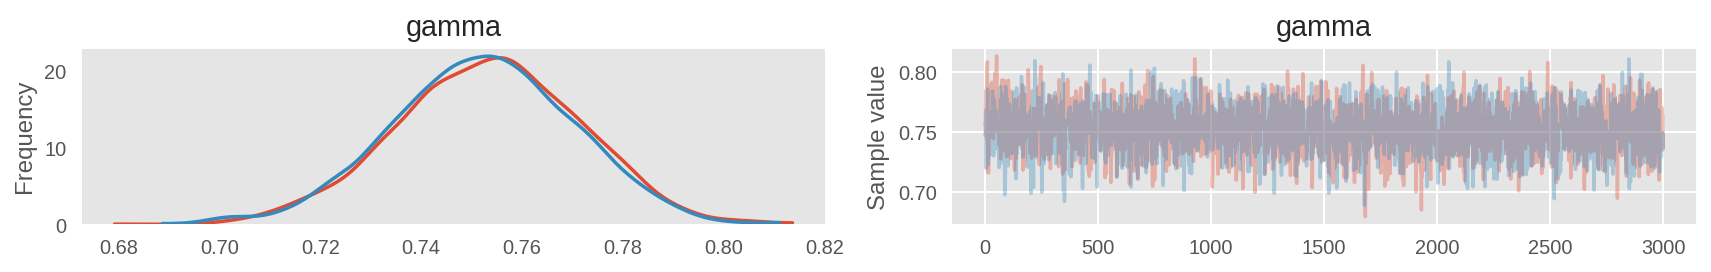

In [4]:
with pm.Model() as model1:
    gamma = pm.Uniform('gamma', lower=.5, upper=1)
    gammat = tt.stack([1-gamma, .5, gamma])
    yiq = pm.Bernoulli('yiq', p=gammat[tmat], observed=y)
    trace1 = pm.sample(3e3, njobs=2)
    
pm.traceplot(trace1)
plt.show()

100%|██████████| 100/100 [00:01<00:00, 86.95it/s]


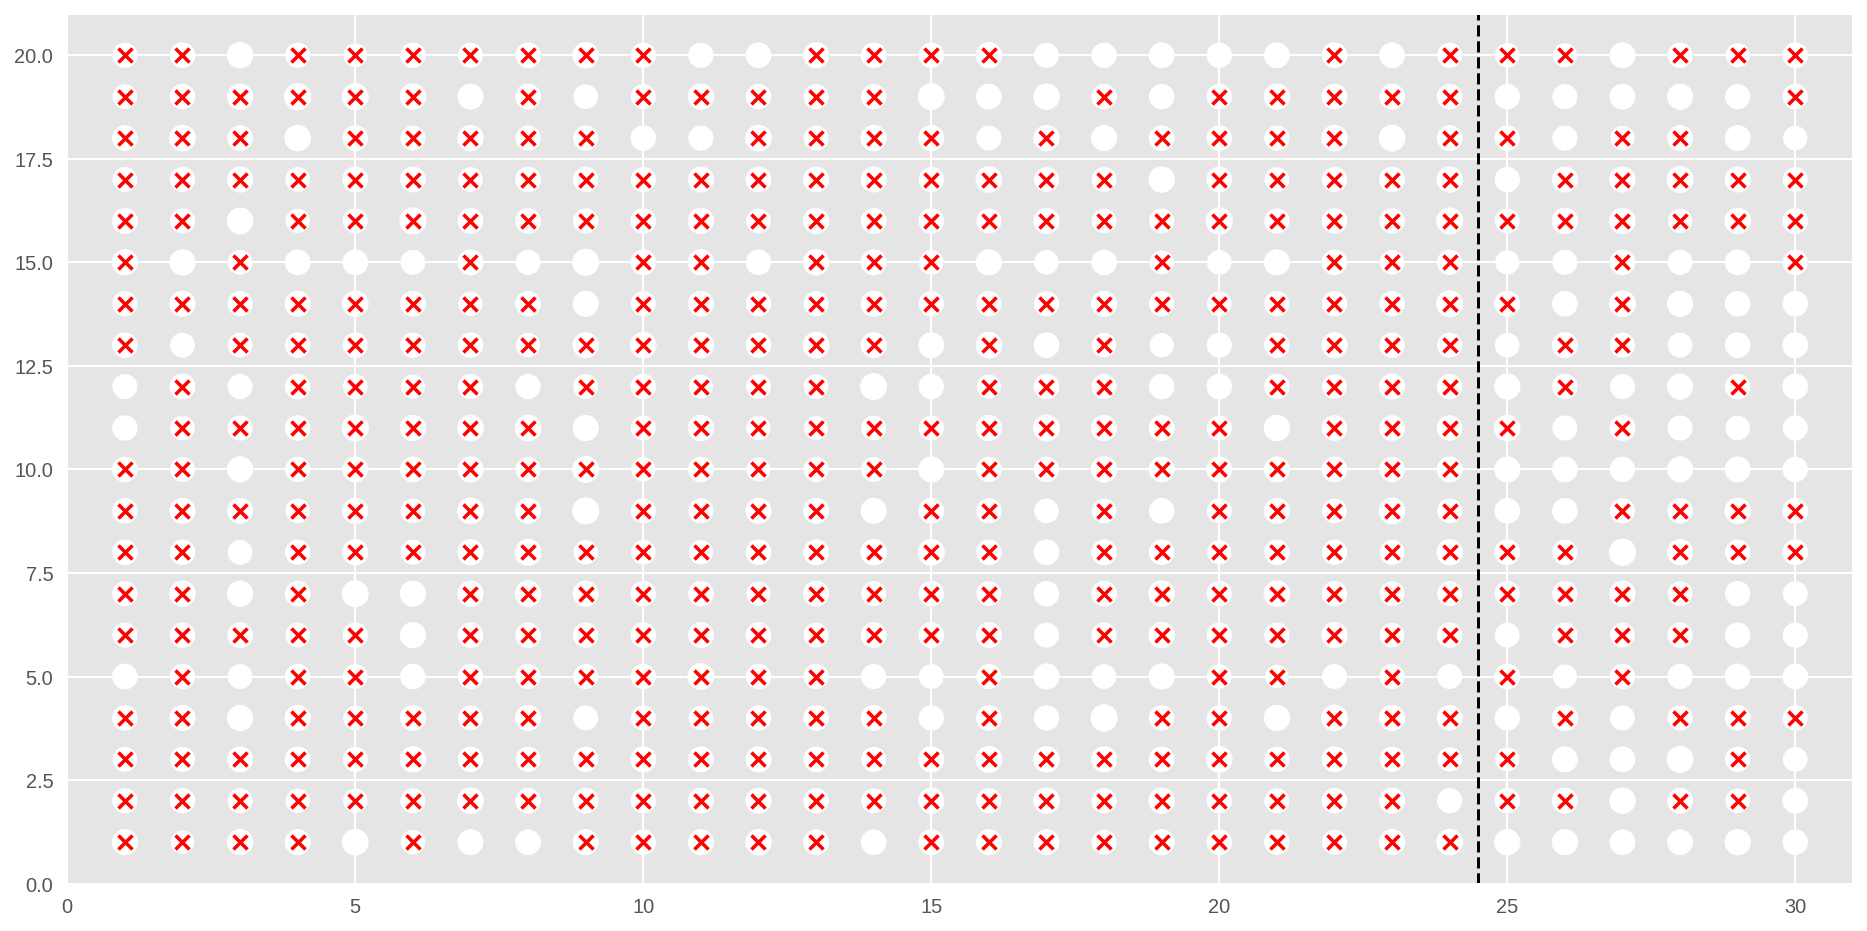

In [5]:
ppc = pm.sample_ppc(trace1, samples=100, model=model1)
yiqpred = np.asarray(ppc['yiq'])
fig = plt.figure(figsize=(16, 8))
x1 = np.repeat(np.arange(ns)+1, nq).reshape(ns, -1).flatten()
y1 = np.repeat(np.arange(nq)+1, ns).reshape(nq, -1).T.flatten()

plt.scatter(y1, x1, s=np.mean(yiqpred, axis=0)*200, c='w')
plt.scatter(y1[y.flatten() == 1], x1[y.flatten() == 1], marker='x', c='r')
plt.plot(np.ones(100)*24.5, np.linspace(0, 21, 100), '--', lw=1.5, c='k')
plt.axis([0, 31, 0, 21])
plt.show()

## 18.2 Stopping
A common comparison (e.g., Bergert & Nosofsky, 2007; Lee & Cummins, 2004) is between TTB and a model often called the Weighted ADDitive (WADD) model, which sums the evidence for both decision alternatives over all available cues, and chooses the one with the greatest evidence.

$$ \phi \sim \text{Uniform}(0,1)$$
$$ z_i \sim \text{Bernoulli}(\phi)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ t_{iq} = 
\begin{cases}
\text{TTB}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_i = 1$} \\
\text{WADD}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_i = 0$} \\
\end{cases}  $$  

$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [6]:
# Question cue contributions template
qcc = np.zeros((nq, nc))
for q in range(nq):
    # Add Cue Contributions To Mimic TTB Decision
    for j in range(nc):
        qcc[q, j] = (m[p[q, 0]-1, j]-m[p[q, 1]-1, j])

qccmat = np.tile(qcc[np.newaxis, :, :], (ns, 1, 1))
# TTB Model For Each Question
s = np.argsort(v)  # s[1:nc] <- rank(v[1:nc])
smat = np.tile(s[np.newaxis, :], (ns, nq, 1))
ttmp = np.sum(qccmat*np.power(2, smat), axis=2)
tmat = -1*(-ttmp > 0)+(ttmp > 0)+1
t = tmat[0]
# tmat = np.tile(t[np.newaxis, :], (ns, 1))        

# WADD Model For Each Question
xmat = np.tile(x[np.newaxis, :], (ns, nq, 1))
wtmp = np.sum(qccmat*xmat, axis=2)
wmat = -1*(-wtmp > 0)+(wtmp > 0)+1
w = wmat[0]

print(t)
print(w)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0]


Assigned NUTS to phi_logodds_
Assigned BinaryGibbsMetropolis to zi
Assigned NUTS to gamma_interval_
100%|██████████| 3000/3000.0 [00:13<00:00, 227.88it/s]


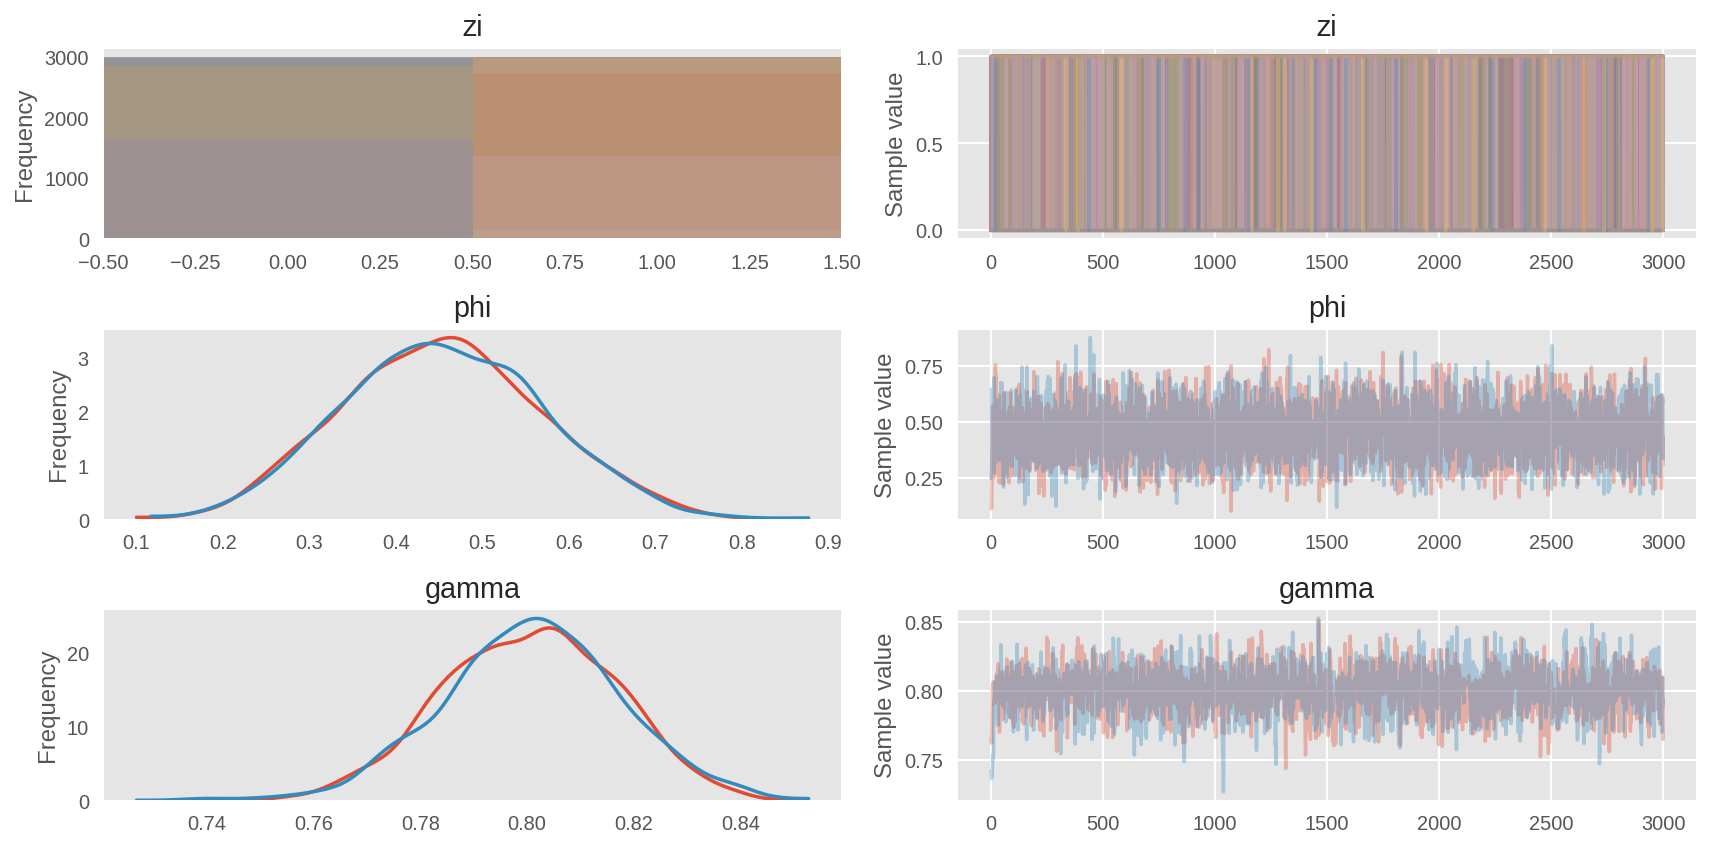

In [7]:
with pm.Model() as model2:
    phi = pm.Beta('phi', alpha=1, beta=1, testval=.01)
    
    zi = pm.Bernoulli('zi', p=phi, shape=ns,
                      testval=np.asarray([1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]))
    zi_ = tt.reshape(tt.repeat(zi, nq), (ns, nq))
    
    gamma = pm.Uniform('gamma', lower=.5, upper=1)
    gammat = tt.stack([1-gamma, .5, gamma])

    t2 = tt.switch(tt.eq(zi_, 1), tmat, wmat)
    yiq = pm.Bernoulli('yiq', p=gammat[t2], observed=y)

    trace2 = pm.sample(3e3, njobs=2)
    
pm.traceplot(trace2)
plt.show()

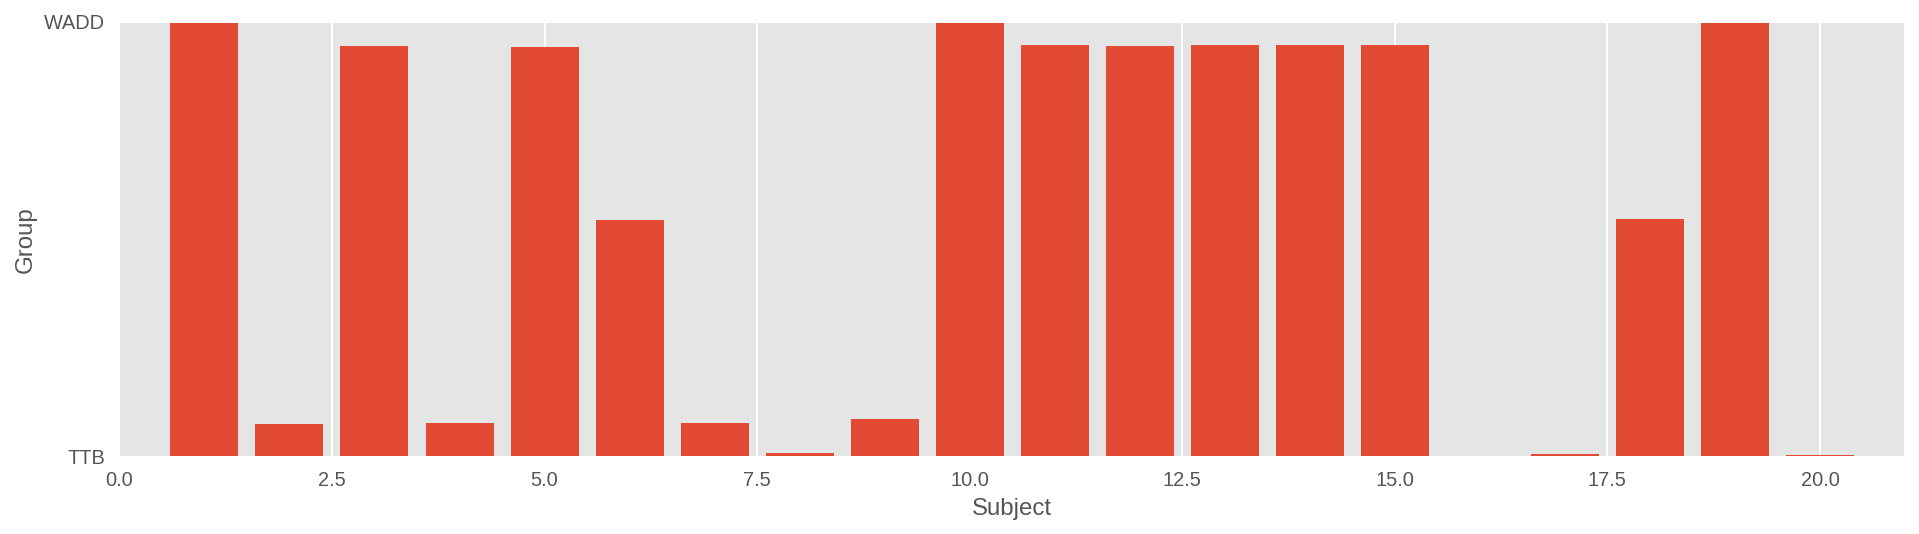

In [8]:
fig = plt.figure(figsize=(16, 4))
zitrc = trace2['zi'][1000:]
plt.bar(np.arange(ns)+1, 1-np.mean(zitrc, axis=0))
plt.yticks([0, 1], ('TTB', 'WADD'))
plt.xlabel('Subject')
plt.ylabel('Group')
plt.axis([0, 21, 0, 1])
plt.show()

## 18.3 Searching


$$ s_i \sim \text{Uniform}((1,...,9),...,(9,...,1))$$
$$ t_{iq} = \text{TTB}_{si}(\mathbf a_q,\mathbf b_q)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -458.07: 100%|██████████| 200000/200000 [01:17<00:00, 2590.94it/s]   
Finished [100%]: Average ELBO = -458.16
100%|██████████| 3000/3000.0 [39:00<00:00,  1.35it/s]


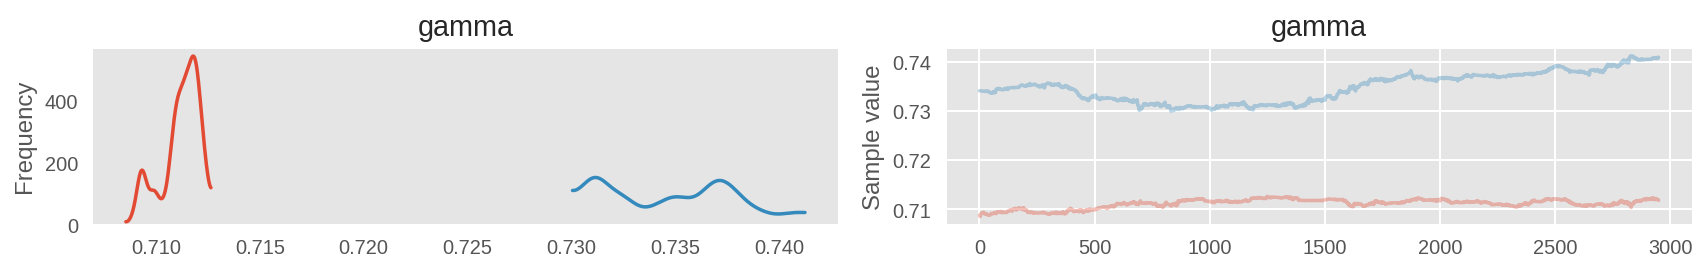

In [16]:
vtmp = np.random.randn(ns, 1, nc)**2
with pm.Model() as model3:
    gamma = pm.Uniform('gamma', lower=.5, upper=1)
    gammat = tt.stack([1-gamma, .5, gamma])
    
    v1 = pm.HalfNormal('v1', sd=1, shape=(ns, 1, nc), testval=vtmp)
    # rng = tt.shared_randomstreams.RandomStreams()
    # v1 = rng.normal(size=(ns, 1, nc))
    # v1 = pm.theanof.tt_rng().normal(size=(ns, 1, nc))
    
    s1 = pm.Deterministic('s1', tt.argsort(v1, axis=2))
    smat2 = tt.tile(s1, (1, nq, 1))  # s[1:nc] <- rank(v[1:nc])
    
    # TTB Model For Each Question
    ttmp = tt.sum(qccmat*tt.power(2, smat2), axis=2)
    tmat = -1*(-ttmp > 0)+(ttmp > 0)+1
    
    yiq = pm.Bernoulli('yiq', p=gammat[tmat], observed=y)
  
    trace3 = pm.sample(3e3, njobs=2, target_accept=.95)

pm.traceplot(trace3[50:], varnames=['gamma'])
plt.show()

The accept rate is: 0.79125
Diverge of the trace
(array([], dtype=int64),)


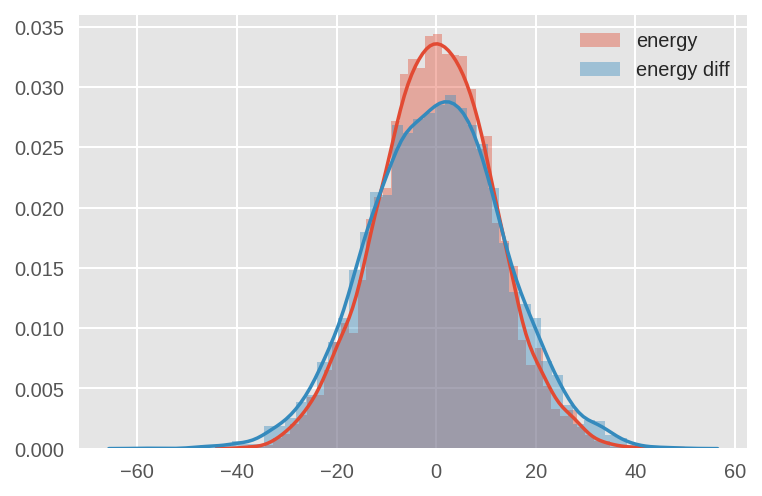

In [17]:
def plot_samplerstat(burnin,trace):
    # Sampler statistics
    accept = trace.get_sampler_stats('mean_tree_accept', burn=burnin)
    print('The accept rate is: %.5f' % (accept.mean()))
    diverge = trace.get_sampler_stats('diverging', burn=burnin)
    print('Diverge of the trace')
    print(diverge.nonzero())
    energy = trace.get_sampler_stats('energy', burn=burnin)
    energy_diff = np.diff(energy)
    sns.distplot(energy - energy.mean(), label='energy')
    sns.distplot(energy_diff, label='energy diff')
    plt.legend()
    plt.show()
    
plot_samplerstat(50,trace3)

0.000268903303759


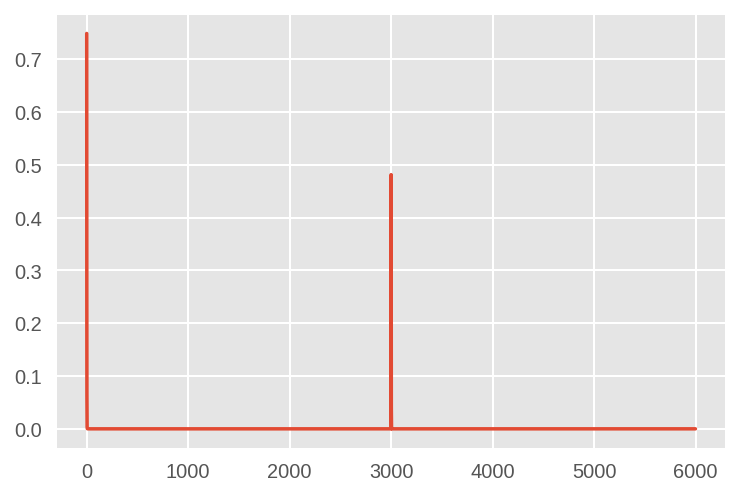

In [18]:
print(trace3['step_size'].mean())
plt.plot(trace3['step_size_bar'])
plt.show()

In [19]:
burnin = 50
# v1trace = np.squeeze(trace3['v1'][burnin:])
# s1trace = np.argsort(v1trace, axis=2)
s1trace = np.squeeze(trace3[burnin:]['s1'])
for subj_id in [12, 13]:
    subj_s = np.squeeze(s1trace[:,subj_id-1,:])
    unique_ord = np.vstack({tuple(row) for row in subj_s})
    num_display = 10
    print('Subject %s' %(subj_id))
    print('There are %s search orders sampled in the posterior.'%(unique_ord.shape[0]))
    mass_ = []
    for s_ in unique_ord:
        mass_.append(np.mean(np.sum(subj_s == s_, axis=1) == len(s_)))
    mass_ = np.asarray(mass_)
    sortmass = np.argsort(mass_)[::-1]
    for i in sortmass[:num_display]:
        s_ = unique_ord[i]
        print('Order=(' + str(s_+1) + '), Estimated Mass=' + str(mass_[i]))

Subject 12
There are 22 search orders sampled in the posterior.
Order=([9 8 5 7 4 6 2 1 3]), Estimated Mass=0.235762711864
Order=([9 8 5 7 4 6 1 2 3]), Estimated Mass=0.164406779661
Order=([7 6 5 2 1 8 4 3 9]), Estimated Mass=0.113050847458
Order=([7 2 5 6 1 8 3 4 9]), Estimated Mass=0.0613559322034
Order=([7 2 5 1 6 8 3 4 9]), Estimated Mass=0.06
Order=([9 8 5 7 4 2 6 1 3]), Estimated Mass=0.045593220339
Order=([7 6 5 2 1 4 8 3 9]), Estimated Mass=0.0437288135593
Order=([7 5 2 6 1 8 3 4 9]), Estimated Mass=0.0401694915254
Order=([9 8 5 7 4 2 6 3 1]), Estimated Mass=0.0342372881356
Order=([7 6 2 5 1 8 4 3 9]), Estimated Mass=0.0301694915254
Subject 13
There are 55 search orders sampled in the posterior.
Order=([2 6 7 4 5 8 3 1 9]), Estimated Mass=0.252542372881
Order=([2 6 7 4 8 5 3 1 9]), Estimated Mass=0.209661016949
Order=([9 2 1 3 5 8 6 4 7]), Estimated Mass=0.137288135593
Order=([9 2 1 5 3 8 7 6 4]), Estimated Mass=0.0733898305085
Order=([9 2 1 5 3 8 6 7 4]), Estimated Mass=0.0608

The return order is not at all similar to the result in JAGS (as shown in the book on p.233).

## 18.4 Searching and stopping


$$ \phi_{i} \sim \text{Uniform}(0,1)$$
$$ z_{iq} \sim \text{Bernoulli}(\phi_{i})$$
$$ s_i \sim \text{Uniform}((1,...,9),...,(9,...,1))$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ t_{iq} = 
\begin{cases}
\text{TTB}_{si}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_{iq} = 1$} \\
\text{WADD}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_{iq} = 0$} \\
\end{cases}  $$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

Assigned NUTS to phi_logodds_
Assigned BinaryGibbsMetropolis to zi
Assigned NUTS to gamma_interval_
Assigned NUTS to v1_log_
100%|██████████| 3000/3000.0 [34:33<00:00,  1.39it/s]


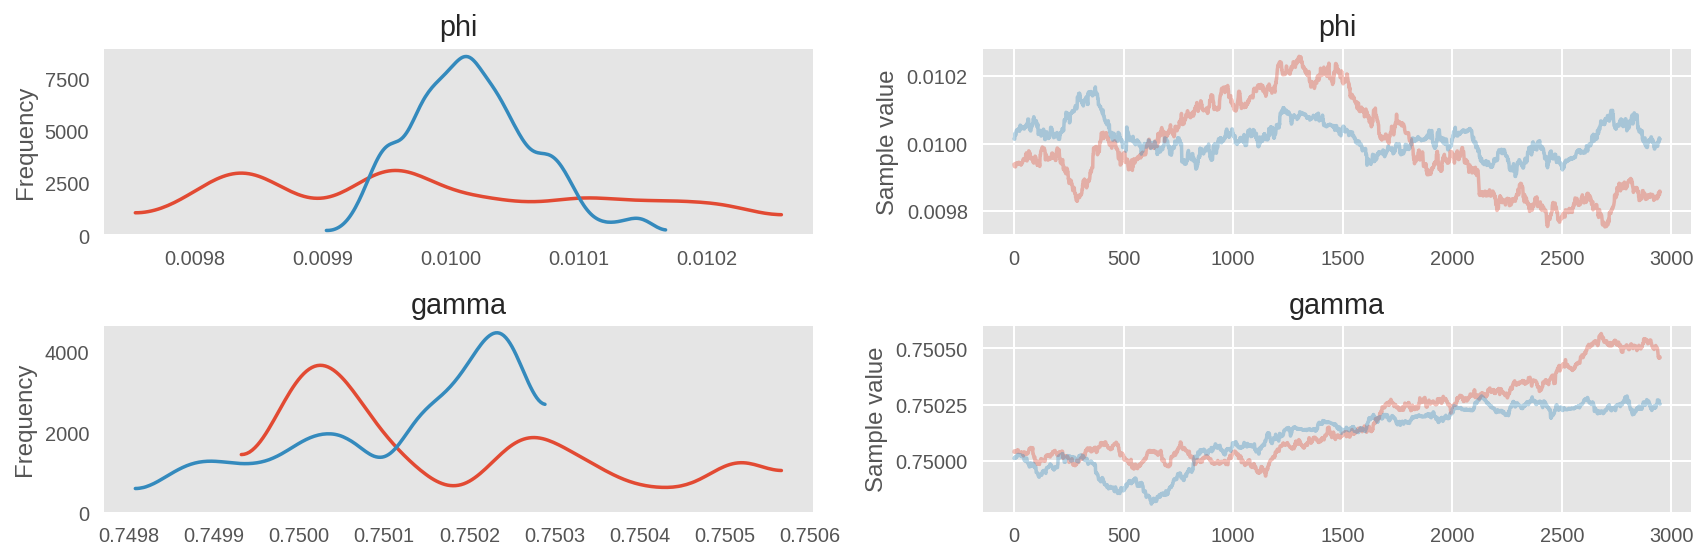

The accept rate is: 0.78905
Diverge of the trace
(array([   2,    6,   10,   13,   17,   21,   37,   41,   45,   48,   52,
         54,   56,   59,   63,   69,   71,   77,   80,   84,   87,   92,
         93,   97,   99,  103,  106,  120,  125,  126,  132,  134,  140,
        144,  146,  149,  158,  161,  165,  166,  168,  169,  180,  181,
        187,  191,  195,  198,  205,  210,  214,  226,  233,  239,  240,
        244,  253,  255,  260,  261,  269,  271,  273,  275,  278,  279,
        280,  285,  288,  293,  295,  299,  304,  309,  316,  317,  328,
        336,  339,  342,  345,  357,  362,  365,  369,  372,  379,  383,
        386,  388,  392,  400,  411,  412,  417,  425,  430,  435,  437,
        450,  451,  452,  454,  461,  466,  468,  473,  478,  480,  486,
        488,  493,  497,  503,  505,  525,  532,  543,  546,  553,  554,
        556,  569,  584,  585,  592,  596,  602,  609,  610,  631,  635,
        645,  660,  665,  673,  677,  680,  683,  690,  692,  694,  695,
 

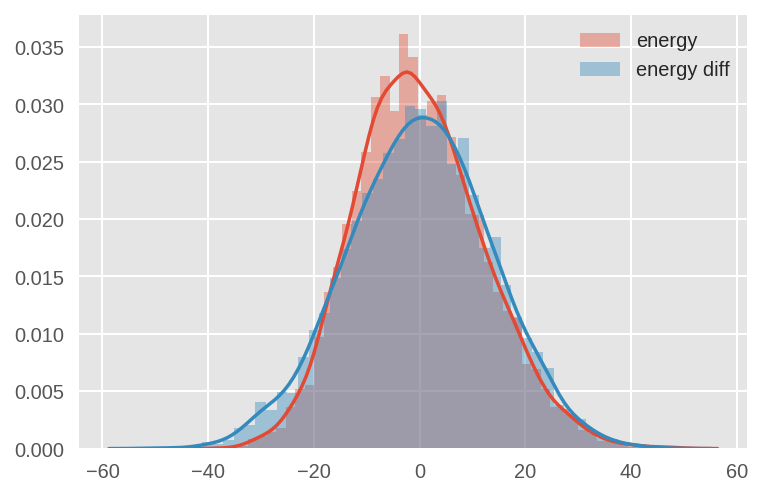

In [20]:
with pm.Model() as model4:
    phi = pm.Beta('phi', alpha=1, beta=1, testval=.01)
    
    zi = pm.Bernoulli('zi', p=phi, shape=ns,
                      testval=np.asarray([1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]))
    zi_ = tt.reshape(tt.repeat(zi, nq), (ns, nq))
    
    gamma = pm.Uniform('gamma', lower=.5, upper=1)
    gammat = tt.stack([1-gamma, .5, gamma])

    v1 = pm.HalfNormal('v1', sd=1, shape=(ns, 1, nc), testval=vtmp)
    s1 = pm.Deterministic('s1', tt.argsort(v1, axis=2))
    smat2 = tt.tile(s1, (1, nq, 1))  # s[1:nc] <- rank(v[1:nc])
    
    # TTB Model For Each Question
    ttmp = tt.sum(qccmat*tt.power(2, smat2), axis=2)
    tmat = -1*(-ttmp > 0) + (ttmp > 0) + 1
            
    t2 = tt.switch(tt.eq(zi_, 1), tmat, wmat)
    yiq = pm.Bernoulli('yiq', p=gammat[t2], observed=y)
    
    trace4 = pm.sample(3e3, njobs=2)

pm.traceplot(trace4[50:], varnames=['phi', 'gamma'])
plt.show()
plot_samplerstat(50,trace4)

100%|██████████| 100/100 [00:01<00:00, 89.74it/s]


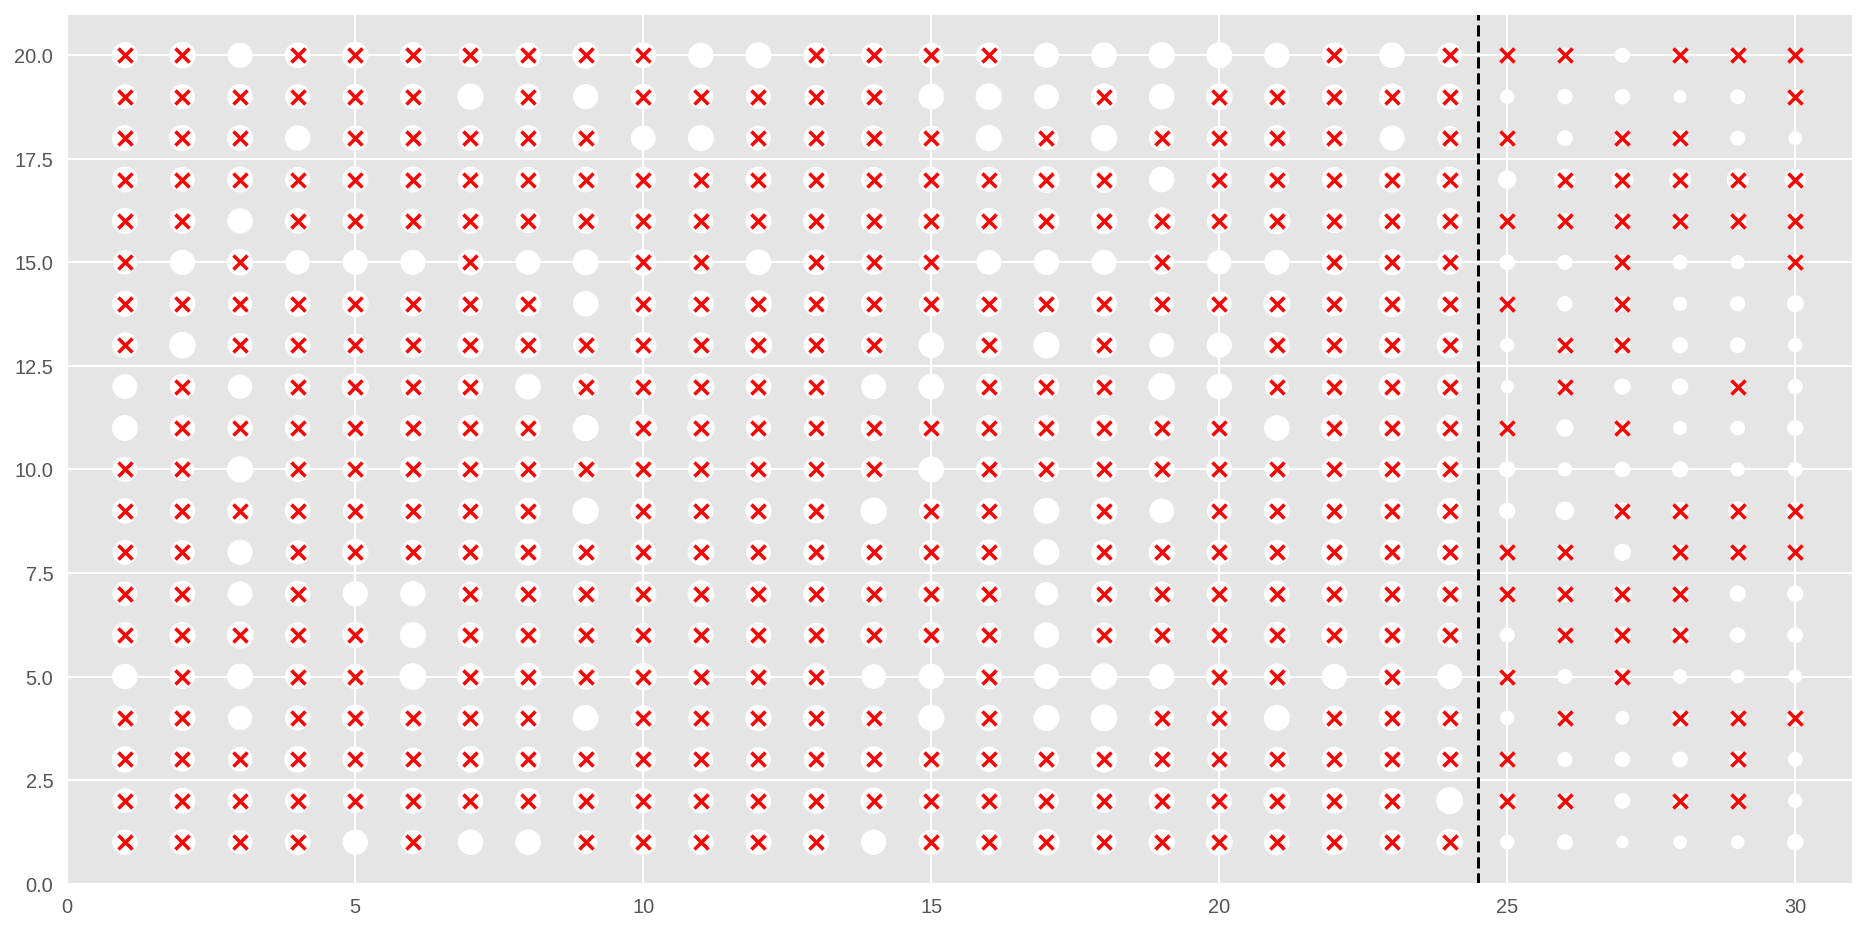

In [21]:
ppc = pm.sample_ppc(trace4[50:], samples=100, model=model4)
yiqpred = np.asarray(ppc['yiq'])
fig = plt.figure(figsize=(16, 8))
x1 = np.repeat(np.arange(ns)+1, nq).reshape(ns, -1).flatten()
y1 = np.repeat(np.arange(nq)+1, ns).reshape(nq, -1).T.flatten()

plt.scatter(y1, x1, s=np.mean(yiqpred, axis=0)*200, c='w')
plt.scatter(y1[y.flatten() == 1], x1[y.flatten() == 1], marker='x', c='r')
plt.plot(np.ones(100)*24.5, np.linspace(0, 21, 100), '--', lw=1.5, c='k')
plt.axis([0, 31, 0, 21])
plt.show()